# Preprosto okno

In [1]:
# importing the libraries
import csv

## Loading the data

In [165]:
# load training data
alltraining = list(csv.reader(open("../../data/training.csv","r"), delimiter=','))

# first line is the list of variables
headertraining = alltraining[0]
# cut off first line
alltraining = alltraining[1:]

# load testing data
alltest = list(csv.reader(open("../../data/test.csv","r"), delimiter=','))
headertest = alltest[0]
alltest = alltest[1:]

## Data Preprocessing

In [166]:
# get the index of a few variables
immc = headertraining.index("DER_mass_MMC")
injet = headertraining.index("PRI_jet_num")
iweight = headertraining.index("Weight")
ilabel = headertraining.index("Label")
iid = headertraining.index("EventId")

In [167]:
# adding a new score field
headertraining += ["myscore"]

# this is a simple discriminating variable. Signal should be closer to zero.
# minus sign so that signal has the highest values
# so we will be making a simple window cut on the Higgs mass estimator
# 125 GeV is the middle of the window

for entry in alltraining:
    # turn all entries from string to float, except EventId and PRI_jet_num to int, except label remains string
    for i in range(len(entry)):
        if not i in [ilabel, iid, injet]:
            entry[i] = float(entry[i])
        if i in [iid, injet]:
            entry[i] = int(entry[i])                        
    myscore=-abs(entry[immc]-125.) 
    entry+=[myscore]

In [133]:
# only used for testing
threshold = -22
# optimized threshold
threshold = -31

In [134]:
# Loop again to determine the AMS, using threshold
sumsig = 0.
sumbkg = 0.
tp = 0.
tn = 0.
fp = 0.
fn = 0.
precision = 0.
recall = 0.
acc = 0.

# id for myscore column
iscore = headertraining.index("myscore")

# only use 10% of training set to calculate metrics
for entry in alltraining[-25000:]:
    myscore = entry[iscore]
    entry += [myscore]
    weight = entry[iweight]
    # sum event weight passing the selection. Of course in real life the threshold should be optimised
    # test for positive
    if myscore > threshold:
        if entry[ilabel] == "s":
            sumsig += weight
            tp += 1
        else:
            sumbkg += weight    
            fp += 1
    else:
        if entry[ilabel] == "s":
            fn += 1
        else:
            tn += 1

In [135]:
# compute AMS
def ams(s, b):
    from math import sqrt,log
    if b==0:
        return 0

    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

In [136]:
# hum, what kind of metrics is not invariant to the number of samples
amsscore = ams(sumsig * 10, sumbkg * 10)

In [137]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
acc = (tp + tn) / (tp + fp + tn + fn)
f1score = (2 * precision * recall)/(precision + recall)

In [138]:
def printScores(tp, tn, fp, fn, precision, recall, acc, f1score, amsscore):
    all = tp + tn + fp + fn
    print("TP: ", tp/all)
    print("TN: ", tn/all)
    print("FP: ", fp/all)
    print("FN: ", fn/all)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Acc: ", acc)
    print("F1: ", f1score)
    print("AMS: ", amsscore)

In [139]:
printScores(tp, tn, fp, fn, precision, recall, acc, f1score, amsscore)

TP:  0.28196
TN:  0.43024
FP:  0.2254
FN:  0.0624
Precision:  0.5557395143487859
Recall:  0.8187942850505285
Acc:  0.7122
F1:  0.6620955243507256
AMS:  1.5730114041168854


## Export the data for Kaggle

In [144]:
#recompute variable indices for safety 
immc = headertest.index("DER_mass_MMC")
injet = headertest.index("PRI_jet_num")
iid = headertest.index("EventId")
headertest += ["myscore"]

for entry in alltest:
    # turn all entries from string to float, except EventId and PRI_jet_num to int (there is no label)
    for i in range(len(entry)):
        if not i in [iid,injet]:
            entry[i]=float(entry[i])
        else:    
            entry[i]=int(entry[i])
    # add my score
    myscore=-abs(entry[immc]-125.)                                    
    entry+=[myscore]

iscore=headertest.index("myscore")
if iscore<0:
    print("ERROR could not find variable myscore")
    raise Exception # should not happen

print("Sort on the score ") 
# in the first version of the file, an auxilliary map was used, but this was useless
alltestsorted=sorted(alltest,key=lambda entry: entry[iscore])
# the RankOrder we want is now simply the entry number

submissionfilename="submission_simplest.csv"
print("Final loop to write the submission file",submissionfilename)
outputfile=open(submissionfilename,"w")
outputfile.write("EventId,RankOrder,Class\n")
iid=headertest.index("EventId")
if iid<0:
    print("ERROR could not find variable EventId in test file")
    raise Exception # should not happen

rank=1 # kaggle wants to start at 1
for entry in alltestsorted:
    # compute label 
    slabel="b"
    if entry[iscore]>threshold: # arbitrary threshold
        slabel="s"

    outputfile.write(str(entry[iid])+",")
    outputfile.write(str(rank)+",")
    outputfile.write(slabel)            
    outputfile.write("\n")
    rank+=1


outputfile.close()
print(" You can now submit ",submissionfilename," to kaggle site")


Sort on the score 
Final loop to write the submission file submission_simplest.csv
 You can now submit  submission_simplest.csv  to kaggle site


## Threshold optimization 

In [87]:
# complete AMS calculation for a threshold
def thresholdAMS(threshold):
    # Loop again to determine the AMS, using threshold
    sumsig = 0.
    sumbkg = 0.
    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    precision = 0.
    recall = 0.
    acc = 0.

    # id for myscore column
    iscore = headertraining.index("myscore")
    
    # only use 10% of training set to calculate metrics
    for entry in alltraining[-25000:]:
        myscore = entry[iscore]
        entry += [myscore]
        weight = entry[iweight]
        # sum event weight passing the selection. Of course in real life the threshold should be optimised
        # test for positive
        if myscore > threshold:
            if entry[ilabel] == "s":
                sumsig += weight
                tp += 1
            else:
                sumbkg += weight    
                fp += 1
        else:
            if entry[ilabel] == "s":
                fn += 1
            else:
                tn += 1
                
    # calculate scores
    amsscore = ams(sumsig * 10, sumbkg * 10)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + fp + tn + fn)
    f1score = (2 * precision * recall)/(precision + recall)

    # printScores(tp, tn, fp, fn, precision, recall, acc, f1score, amsscore)
    
    return amsscore

In [88]:
thresholdAMS(-10)

1.1841351593597689

### Create AMS(threshold) chart

In [116]:
amsgraphX = []
amsgraphY = []
for i in range(-500, -100, 1):
    amsgraphX.append(i/10.)
    amsgraphY.append(thresholdAMS(i/10.))


In [117]:
# import
%matplotlib inline
import matplotlib.pyplot as plt

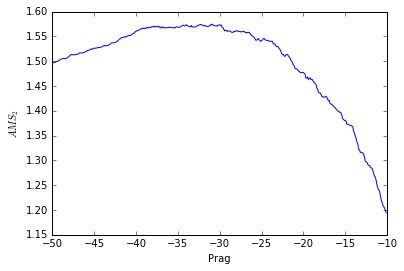

In [118]:
plt.plot(amsgraphX, amsgraphY, 'b-')
plt.xlabel('Prag')
plt.ylabel('$AMS_2$')
plt.savefig('sw_amslearn.pdf')

In [122]:
# more detail
amsgraphX = []
amsgraphY = []
for i in range(-400, -290, 1):
    amsgraphX.append(i/10.)
    amsgraphY.append(thresholdAMS(i/10.))


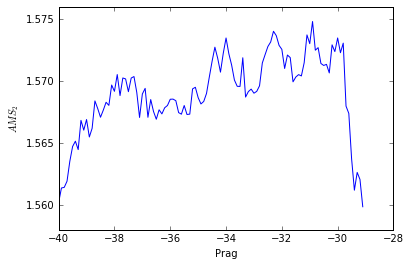

In [123]:
plt.plot(amsgraphX, amsgraphY, 'b-')
plt.xlabel('Prag')
plt.ylabel('$AMS_2$')
plt.savefig('sw_amslearn_detail.pdf')

## 2D optimization on threshold and $m_H$

In [312]:
def thresholdMassAMS(threshold, mass):
    # id for myscore column
    iscore = headertraining.index("myscore")
    
    for entry in alltraining:                              
        myscore=-abs(entry[immc]-mass) 
        entry[iscore] = myscore
    
    # Loop again to determine the AMS, using threshold
    sumsig = 0.
    sumbkg = 0.
    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    precision = 0.
    recall = 0.
    acc = 0.   
    
    # only use 10% of training set to calculate metrics
    for entry in alltraining[-25000:]:
        myscore = entry[iscore]
        entry += [myscore]
        weight = entry[iweight]
        # sum event weight passing the selection. Of course in real life the threshold should be optimised
        # test for positive
        if myscore > threshold:
            if entry[ilabel] == "s":
                sumsig += weight
                tp += 1
            else:
                sumbkg += weight    
                fp += 1
        else:
            if entry[ilabel] == "s":
                fn += 1
            else:
                tn += 1
                
    # calculate scores
    # print(sumsig, sumbkg)
    amsscore = ams(sumsig * 10, sumbkg * 10)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + fp + tn + fn)
    f1score = (2 * precision * recall)/(precision + recall)

    printScores(tp, tn, fp, fn, precision, recall, acc, f1score, amsscore)
    
    return amsscore

In [232]:
thresholdMassAMS(-31., 125.)

1.5730114041168854

### Plotting

In [171]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

In [277]:
# general        
X = np.arange(-50, -20, 2)
Y = np.arange(120, 140, 2)
X, Y = np.meshgrid(X, Y)
Z = np.sqrt(abs(X))
for i in range(len(X[:,1])):
    for j in range(len(Y[1])):
        Z[i, j] = thresholdMassAMS(X[i, j], Y[i, j])
        print(Z[i, j])


1.4756172244
1.48435901283
1.49555266003
1.50688391184
1.51446865058
1.52615602501
1.531444988
1.54674141678
1.55708328755
1.55560651507
1.54271084907
1.53830377484
1.51895767552
1.49082277941
1.46793805871
1.48348275167
1.4970776715
1.50767064214
1.51475206198
1.52523875149
1.5361312336
1.55301243213
1.56389950014
1.56576188461
1.55715588079
1.56038019586
1.55300959807
1.5369314812
1.51337858151
1.48395889594
1.49240131106
1.50639894909
1.51588876807
1.52552576815
1.53572262671
1.55105967234
1.56762585731
1.57106062586
1.56321075056
1.56993688129
1.5668783318
1.55858784874
1.54755345261
1.53092498306
1.50427599056
1.49805625429
1.5107311539
1.52379584307
1.53634344507
1.55062234179
1.56621391959
1.56801072059
1.56633136418
1.57432398611
1.5716446973
1.56742070783
1.56089877697
1.55196461439
1.53840778512
1.51023957867
1.49978230433
1.51477243246
1.53055016848
1.54823760921
1.5660842631
1.56681331384
1.56423679644
1.57021432222
1.57376600132
1.57071843032
1.56438663439
1.55984969218
1.

In [290]:
# detail        
X = np.arange(-36, -31, 0.25)
Y = np.arange(124, 129, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.sqrt(abs(X))
for i in range(len(X[:,1])):
    for j in range(len(Y[1])):
        Z[i, j] = thresholdMassAMS(X[i, j], Y[i, j])
        print(Z[i, j])

1.57106062586
1.57009475126
1.56969300905
1.56916102124
1.56921957963
1.5671512563
1.56729506887
1.56561454917
1.56321075056
1.56328546128
1.56633767555
1.56874341362
1.57019616753
1.56799394463
1.56530236475
1.56669376616
1.56993688129
1.57096101666
1.57206468332
1.57249809273
1.56868842123
1.5694169124
1.56947022823
1.57073309026
1.5685939613
1.56878671194
1.5681416154
1.56596846412
1.56390468469
1.56585475516
1.56775800122
1.56977117366
1.56839449258
1.56777632559
1.56802406962
1.56757770669
1.57029695387
1.57326840401
1.57361001418
1.57139167416
1.56749841042
1.56804697788
1.57044147505
1.56889418416
1.57030048083
1.56958222055
1.56745698728
1.56643563899
1.56860627797
1.56834029745
1.56926295953
1.56739045046
1.56733538523
1.56839979129
1.57003422649
1.57159981836
1.57085188802
1.57290222138
1.5725823844
1.57168334138
1.5680499009
1.56849236498
1.56745056335
1.56999760061
1.56987198103
1.56897186156
1.56787680851
1.57008182313
1.57086654158
1.5720067103
1.56795448686
1.56681394051

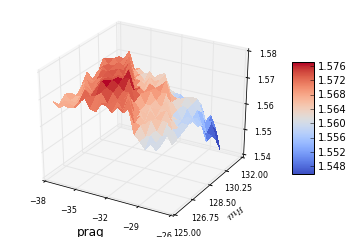

In [276]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_major_locator(LinearLocator(5))
ax.yaxis.set_major_locator(LinearLocator(5))
ax.set_xlabel("prag", fontsize=12)
ax.set_ylabel("$m_H$", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)

fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('sw_amslearn_2d_detail.pdf')

### Contour plot

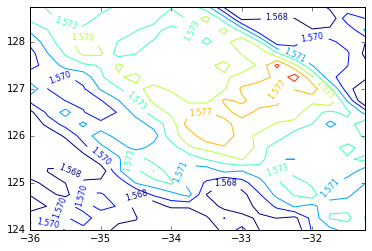

In [296]:
plt.figure()
levels = np.linspace(1.568, 1.580, 8)
CS = plt.contour(X, Y, Z, levels=levels)
plt.clabel(CS, inline=1, fontsize=8)
plt.savefig("sw_amslearn_2d_contour_detail.pdf")
# plt.savefig("sw_amslearn_2d_contour.pdf")

In [302]:
np.argmax(Z)

275

In [309]:
Z[275/20, 15]

C:\Users\kkenda\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


1.5792122648365183

In [310]:
X[275/20, 15]

C:\Users\kkenda\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


-32.25

In [311]:
Y[275/20, 15]

C:\Users\kkenda\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


127.25

In [313]:
thresholdMassAMS(-32.25, 127.25)

TP:  0.2838
TN:  0.43244
FP:  0.2232
FN:  0.06056
Precision:  0.5597633136094674
Recall:  0.8241375304913463
Acc:  0.71624
F1:  0.6666979890997933
AMS:  1.5792122648365183


1.5792122648365183

### Export for Kaggle

In [315]:
#recompute variable indices for safety 
immc = headertest.index("DER_mass_MMC")
injet = headertest.index("PRI_jet_num")
iid = headertest.index("EventId")
headertest += ["myscore"]
threshold = -32.25
for entry in alltest:
    # turn all entries from string to float, except EventId and PRI_jet_num to int (there is no label)
    for i in range(len(entry)):
        if not i in [iid,injet]:
            entry[i]=float(entry[i])
        else:    
            entry[i]=int(entry[i])
    # add my score
    myscore=-abs(entry[immc]-127.25)                                    
    entry+=[myscore]

iscore=headertest.index("myscore")
if iscore<0:
    print("ERROR could not find variable myscore")
    raise Exception # should not happen

print("Sort on the score ") 
# in the first version of the file, an auxilliary map was used, but this was useless
alltestsorted=sorted(alltest,key=lambda entry: entry[iscore])
# the RankOrder we want is now simply the entry number

submissionfilename="submission_simplest_2d.csv"
print("Final loop to write the submission file",submissionfilename)
outputfile=open(submissionfilename,"w")
outputfile.write("EventId,RankOrder,Class\n")
iid=headertest.index("EventId")
if iid<0:
    print("ERROR could not find variable EventId in test file")
    raise Exception # should not happen

rank=1 # kaggle wants to start at 1
for entry in alltestsorted:
    # compute label 
    slabel="b"
    if entry[iscore]>threshold: # arbitrary threshold
        slabel="s"

    outputfile.write(str(entry[iid])+",")
    outputfile.write(str(rank)+",")
    outputfile.write(slabel)            
    outputfile.write("\n")
    rank+=1


outputfile.close()
print(" You can now submit ",submissionfilename," to kaggle site")

Sort on the score 
Final loop to write the submission file submission_simplest_2d.csv
 You can now submit  submission_simplest_2d.csv  to kaggle site
